# APRs y Embeddings: Algoritmo de DNN
---

# Drive, librerias, etc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
import h5py
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,  roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import os

import tensorflow as tf
from tensorflow import keras

Importamos el Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ruta inicial de las amyloid proteins

In [ ]:
ruta_apr_cpad = '/content/drive/MyDrive/aggregation_itba/data/En uso/cpad.csv'

In [ ]:
# Lee el archivo TSV en un DataFrame de pandas
#df_desorden = pd.read_csv(ruta_desorden_amyprot, sep='\t')
df_inicial = pd.read_csv(ruta_apr_cpad)

In [ ]:
df_inicial

,id_in_source,uniprot_id,category,start,end,length,source,peptide,protein_sequence,mutant
0,P-0026,P0ABK7,amyloid,46,51,6,cpad,AAIIGQ,MKNKLLFMMLTILGAPGIAAAAGYDLANSEYNFAVNELSKSSFNQA...,False
1,P-0042,P02766,amyloid,111,116,6,cpad,AEVVFT,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,False
2,P-0047,P01034,amyloid,84,89,6,cpad,AGVNYF,MAGPLRAPLLLLAILAVALAVSPAAGSSPGKPPRLVGGPMDASVEE...,False
3,P-0051,P05067,amyloid,701,706,6,cpad,AIIGLM,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,False
4,P-0052,P10997,amyloid,58,63,6,cpad,AILSST,MGILKLQVFLIVLSVALNHLKATPIESHQVEKRKCNTATCATQRLA...,False
...,...,...,...,...,...,...,...,...,...,...
658,P-2015,P05067,amyloid,672,713,42,cpad,DAEFRHDSGYEVHHQKLVFFAEKVGSNDGAIIGLLVGGVVIA,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,True
659,P-2016,P05067,amyloid,672,713,42,cpad,DAEFRHDSGYEVHHQKLVFFAEKVGSNKGAIIGLLVGGVVIA,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,True
660,P-2017,P05067,amyloid,672,713,42,cpad,DAEFRHDSGYEVHHQKLVGFAEDVGSNKGAIIGLLVGFVVIA,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,True
661,P-2018,P05067,amyloid,672,713,42,cpad,DAEFRHDSGYEVHHQKLVGFAEDVGSNKGAIIGLLVGGVVIA,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,True


# Analisis y pre-procesamiento de los embeddings

*Nos encargamos de generar un dataframe final con columna de embedding, aminoacido y etiqueta APR*

## Generar el dataframe final con la información de las secuencias APR y sus embeddings

### Vemos si hay registros nulos

No tiene registros nulos

In [ ]:
# Buscar registros que tienen al menos un NaN
df_nan = df_inicial[df_inicial.isnull().any(axis=1)]

df_nan

,id_in_source,uniprot_id,category,start,end,length,source,peptide,protein_sequence,mutant


¿Que uniprot_ids tenemos hasta ahora?

In [ ]:
uniprot_ids = df_inicial['uniprot_id'].unique()
uniprot_ids

array(['P0ABK7', 'P02766', 'P01034', 'P05067', 'P10997', 'P02647',
       'P14859', 'P61823', 'P00441', 'P23202', 'P04156', 'P01258',
       'P27986', 'P37840', 'P14621', 'P02671', 'P00698', 'Q13148',
       'P10155', 'P61769', 'P06396', 'P06654', 'Q13480', 'P28307',
       'Q5A8T4', 'P49247', 'Q96QU1', 'B1W2X5', 'Q9AD92', 'P06865',
       'Q8N3I7', 'P98161', 'P05121', 'Q9Y572', 'P18505', 'Q01974',
       'Q99678', 'P02743', 'P13569', 'O75844', 'P49810', 'Q8NEZ4',
       'Q9Y231', 'Q9NYW4', 'O60479', 'Q9HC10', 'P54132', 'P61626',
       'P06280', 'P42574', 'P29122', 'P01607', 'P35637', 'P02511',
       'P10636', 'P08195', 'P01308', 'Q8TCU4', 'P04925', 'P04273',
       'P53708', 'Q12866', 'P14922', 'Q9UHC1', 'P32770', 'P67986',
       'P05453', 'Q92973', 'Q10472', 'P15144', 'Q15428', 'P16499',
       'Q9NR23', 'O15354', 'Q86YQ2', 'O14775', 'O43347', 'Q9Y5E7',
       'Q9UKN7', 'P49750', 'P02649', 'P06881', 'P04637', 'G1UBC2',
       'Q86UK0', 'Q9Y2U8', 'P32081', 'E9P9G2', 'Q8WXD0', 'Q9NZ

¿Cuantos son?

In [ ]:
len(uniprot_ids)

159

### Obtenemos los embeddings con sus respectivos uniprot_id

In [ ]:
directory = '/content/drive/MyDrive/aggregation_itba/data/embeddings_proteins_cpad'
directory_seg = '/content/drive/MyDrive/aggregation_itba/data/embeddings_cpad'

In [ ]:
# Lista para almacenar los datos de cada archivo .npy
data_list = []

# Iterar sobre cada archivo en el directorio
for filename in os.listdir(directory):
    if filename.endswith('.npy'):
        file_path = os.path.join(directory, filename)
        # Eliminar la extensión .npy del nombre del archivo para obtener el id_in_source
        file_id = os.path.splitext(filename)[0]
        # Cargar el archivo .npy
        data = np.load(file_path)
        # Crear un DataFrame temporal con dos columnas: 'id_in_source' y 'embedding'
        df_temp = pd.DataFrame({
            'uniprot_id': [file_id],
            'embedding': [data]
        })
        # Agregar el DataFrame temporal a la lista
        data_list.append(df_temp)

# Concatenar todos los DataFrames temporales en uno solo
embeddings_full = pd.concat(data_list, ignore_index=True)

# Mostrar el DataFrame resultante
embeddings_full

,uniprot_id,embedding
0,B1W2X5,"[[0.07647289, -0.16419601, -0.0012950562, 0.01..."
1,B7IS13,"[[0.013065758, 0.017211618, 0.23004746, 0.2358..."
2,E9P9G2,"[[0.25245184, -0.08833857, 0.05664199, 0.55265..."
3,O14775,"[[0.13592699, 0.020750158, -0.16338196, 0.1797..."
4,G1UBC2,"[[0.09555628, -0.16103204, 0.12797056, 0.60030..."
...,...,...
161,P02647,"[[0.115427084, -0.2087668, 0.17351498, 0.46064..."
162,P04156,"[[0.05570587, -0.26847672, 0.06631588, 0.29026..."
163,P04273,"[[0.075227015, -0.25885397, 0.054962873, 0.289..."
164,P05067,"[[0.12844488, -0.21410654, 0.18284735, 0.34963..."


In [ ]:
# Lista para almacenar los datos de cada archivo .npy
data_list2 = []

# Iterar sobre cada archivo en el directorio
for filename in os.listdir(directory_seg):
    if filename.endswith('.npy'):
        file_path = os.path.join(directory_seg, filename)
        # Eliminar la extensión .npy del nombre del archivo para obtener el id_in_source
        file_id = os.path.splitext(filename)[0]
        # Cargar el archivo .npy
        data = np.load(file_path)
        # Crear un DataFrame temporal con dos columnas: 'id_in_source' y 'embedding'
        df_temp = pd.DataFrame({
            'id_in_source': [file_id],
            'embedding_seg': [data]
        })
        # Agregar el DataFrame temporal a la lista
        data_list2.append(df_temp)

# Concatenar todos los DataFrames temporales en uno solo
embeddings_seg = pd.concat(data_list2, ignore_index=True)

# Mostrar el DataFrame resultante
embeddings_seg

,id_in_source,embedding_seg
0,P-0110,"[[0.111011796, -0.03674714, -0.24116984, -0.09..."
1,P-0071,"[[0.018434908, 0.016591122, -0.04022753, 0.238..."
2,P-0090,"[[0.072077595, 0.0049781054, -0.23169515, 0.17..."
3,P-0111,"[[0.19878213, -0.02392345, -0.33840263, -0.066..."
4,P-0103,"[[0.10756222, 0.03546576, -0.20649414, 0.07013..."
...,...,...
658,P-1998,"[[-0.1018913, -0.24079901, 0.05010129, 0.27564..."
659,P-2012,"[[0.08582574, -0.2568548, -0.31072235, 0.24704..."
660,P-1991,"[[0.030422017, -0.26178512, -0.24764489, 0.152..."
661,P-2000,"[[0.05361948, -0.19665027, -0.2267329, 0.11594..."


In [ ]:
df = df_inicial.merge(embeddings_full, on='uniprot_id', how='left')
df = df.merge(embeddings_seg, on='id_in_source', how='left')

Seguimos sin registros nulos

In [ ]:
# Buscar registros que tienen al menos un NaN
df_nan2 = df[df.isnull().any(axis=1)]

df_nan2

,id_in_source,uniprot_id,category,start,end,length,source,peptide,protein_sequence,mutant,embedding,embedding_seg


## Funciones para generar los inputs

In [ ]:
def generateAPRlabels(df, id_field, sequence_field, start_field, end_field):
  # Crear un diccionario vacío para almacenar los resultados
  APR_dic = {}

  # Iterar sobre los valores únicos de uniprot_id
  for uniprot_id in df[id_field].unique():
    if(uniprot_id != "P25391"):
        # Filtrar el DataFrame para obtener solo las filas correspondientes a uniprot_id actual
        subconjunto_df = df[df[id_field] == uniprot_id]

        # Inicializar un vector de ceros con la longitud de la secuencia completa
        full_seq_len = len(subconjunto_df.iloc[0][sequence_field])
        vector = np.zeros(full_seq_len)
        #print(uniprot_id, full_seq_len)
        # Iterar sobre las filas del subconjunto DataFrame para llenar con unos las regiones APR
        for _, fila in subconjunto_df.iterrows():
            start_apr = fila[start_field]
            end_apr = fila[end_field]
            vector[start_apr - 1:end_apr] = 1  # Indices basados en cero

        # Almacenar el vector en el diccionario usando uniprot_id como clave
        APR_dic[uniprot_id] = vector

  APR_labels = np.concatenate(list(APR_dic.values()))

  #Chequeo
  """
  # Seleccionar aleatoriamente 3 uniprot_id y verificar los vectores generados
  random_uniprot_ids = np.random.choice(list(APR_dic.keys()), 3, replace=False)
  for uniprot_id in random_uniprot_ids:
      print(f"uniprot_id: {uniprot_id}")
      print(f"Vector generado: {APR_dic[uniprot_id]}")

      # Verificar las regiones APR en el DataFrame original
      original_regions = df[df[id_field] == uniprot_id][[start_field, end_field]]
      for _, row in original_regions.iterrows():
          start_apr = row[start_field] - 1
          end_apr = row[end_field]
          print(f"Región APR en DataFrame original: start={start_apr + 1}, end={end_apr}, valores en vector: {APR_dic[uniprot_id][start_apr:end_apr]}")
      print("\n")
  """


  return APR_labels

In [ ]:
def generateAAVector(df, id_field, sequence_field):
  # Inicializar la variable para almacenar el total de aminoácidos
  total_aminoacidos = 0
  concatenated_sequence_list = []
  # Iterar sobre los valores únicos de uniprot_id
  for uniprot_id in df[id_field].unique():
    if(uniprot_id != "P25391"):
      # Filtrar el DataFrame para obtener solo las filas correspondientes a uniprot_id actual
      subconjunto_df = df[df[id_field] == uniprot_id]

      # Obtener la longitud de la secuencia completa y sumarla al total de aminoácidos
      total_aminoacidos += len(subconjunto_df.iloc[0][sequence_field])

      # Inicializar un vector de ceros con la longitud de la secuencia completa
      full_seq = subconjunto_df.iloc[0][sequence_field]
      for aa in full_seq:
        concatenated_sequence_list.append(aa)

  # Mostrar el total de aminoácidos
  print("Total de aminoácidos en todas las secuencias de proteínas:", total_aminoacidos)

  # Convertir la lista concatenada en un vector numpy
  aa_vector = np.array(concatenated_sequence_list)

  print("Longitud total de la secuencia concatenada:", len(aa_vector))
  print("Vector de aminoácidos:", aa_vector)

  return aa_vector

In [ ]:
def generateEmbeddingsMatrix(df, id_field = "uniprot_id", embeddings_field = "embedding"):
  concatenated_embeddings_list = []
  for uniprot_id in df[id_field].unique():
    if(uniprot_id != "P25391"):
      # Filtrar el DataFrame para obtener solo las filas correspondientes a uniprot_id actual
      subconjunto_df = df[df[id_field] == uniprot_id]

      # Inicializar un vector de ceros con la longitud de la secuencia completa
      full_embedding = subconjunto_df.iloc[0][embeddings_field]
      for embedding in full_embedding:
        concatenated_embeddings_list.append(embedding)

      #print(uniprot_id, len(full_embedding))

  embeddings = np.array(concatenated_embeddings_list)
  return embeddings

In [ ]:
def generateInputs(df, id_field = "uniprot_id", sequence_field = "protein_sequence", start_field = "start", end_field = "end", embeddings_field = "embedding"):

  APR_labels = generateAPRlabels(df, id_field, sequence_field, start_field, end_field)
  aa_vector = generateAAVector(df, id_field, sequence_field)
  embeddings =  generateEmbeddingsMatrix(df, id_field, embeddings_field)

  return embeddings, APR_labels, aa_vector

In [ ]:
# Lista de uniprot_ids que deseas excluir
exclude_ids = [
    'P25391', 'P02647', 'P37840', 'P10997', 'P10997',
    'P10997', 'P10997', 'P61823', 'P04156', 'P37840',
    'P05067', 'P05067', 'P05067', 'P05067', 'P04273'
]

# Crear el nuevo DataFrame excluyendo los registros con esos id_in_source
df_sampled = df[~df['uniprot_id'].isin(exclude_ids)]

In [ ]:
embeddings, APR_labels, aa_vector = generateInputs(df_sampled)

Total de aminoácidos en todas las secuencias de proteínas: 92461
Longitud total de la secuencia concatenada: 92461
Vector de aminoácidos: ['M' 'K' 'N' ... 'Y' 'Y' 'I']


Se solapan

In [ ]:
embeddings_list = [list(embedding) for embedding in embeddings]
df_5 = pd.DataFrame({
    'Embedding': embeddings_list,
    'APR_labels': APR_labels,
    "Aminoacido": aa_vector
})

# Mostrar las primeras filas del DataFrame para verificar
df_5

,Embedding,APR_labels,Aminoacido
0,"[0.070666276, -0.29747915, 0.19358568, 0.02028...",0.0,M
1,"[-0.1811695, -0.2556704, 0.01931181, 0.1090329...",0.0,K
2,"[-0.25803804, -0.1896459, 0.15480956, 0.202103...",0.0,N
3,"[-0.10615153, -0.21880713, 0.12286062, 0.02728...",0.0,K
4,"[-0.06406017, 0.10448515, 0.12529337, -0.27173...",0.0,L
...,...,...,...
92456,"[0.17148301, 0.16389948, 0.22219963, -0.133129...",0.0,P
92457,"[0.042266365, 0.11994776, -0.017350763, -0.094...",0.0,L
92458,"[0.07609621, 0.11811169, 0.1971093, -0.2223790...",0.0,Y
92459,"[-0.053754807, 0.029409613, 0.14904973, -0.065...",0.0,Y


## Calculamos la proporción de registros no - APR que tenemos que seleccionar para generar n cantidad de modelos con relación 1:1 APR/no-APR

In [ ]:
# Paso 2: Filtrar los registros que no son APR
no_apr_df = df_5[df_5['APR_labels'] == 0]

# Paso 3: Filtrar los registros que son APR
apr_df = df_5[df_5['APR_labels'] == 1]

In [ ]:
cant_modelos = round(len(no_apr_df)/len(apr_df))
print("Cantidad de modelos totales:", round(cant_modelos))

Cantidad de modelos totales: 40


In [ ]:
proporcion = len(apr_df)/len(no_apr_df)
proporcion

0.02493016450139671

In [ ]:
from collections import Counter
# Paso 1: Calcular la frecuencia de cada aminoácido en el vector original
aminoacid_counts = Counter(df_5['Aminoacido'])
total_aa = len(aa_vector)
aa_proportions = {aa: count / total_aa for aa, count in aminoacid_counts.items()}

Función para generar las 40 matrices con misma cantidad de registros APR y no-APR sin repetir registros de tipo no-APR entre matrices

In [ ]:
def generate_balanced_dfs(df_5, no_apr_df, aminoacid_counts, n_iterations=10, proporcion=0.05, no_repeat = False):
    balanced_dfs = []

    # Hacer una copia del no_apr_df para no modificar el original
    available_no_apr_df = no_apr_df.copy()

    for i in range(n_iterations):
        # Paso 3: Para cada aminoácido, seleccionar un subconjunto proporcional
        reduced_no_apr_df_list = []

        if(no_repeat):
            # Calcular cuántos registros mantener para este aminoácido
            n_to_keep = int(len(no_apr_df) * proporcion) #(2249 aminoacidos)
            # Seleccionar un subconjunto aleatorio de esos registros
            reduced_aa_subset = available_no_apr_df.sample(n=n_to_keep)  # random_state para reproducibilidad
            # Guardar en la lista
            reduced_no_apr_df_list.append(reduced_aa_subset)
            # Eliminar los registros seleccionados del available_no_apr_df para no reutilizarlos
            available_no_apr_df = available_no_apr_df.drop(reduced_aa_subset.index)
        else:
          for aa in aminoacid_counts:
              # Filtrar los registros correspondientes a un aminoácido específico en no APR
              aa_subset = available_no_apr_df[available_no_apr_df['Aminoacido'] == aa]

              # Calcular cuántos registros mantener para este aminoácido
              n_to_keep = int(len(aa_subset) * proporcion)

              # Asegurarse de que al menos 1 registro sea mantenido
              if n_to_keep < 1:
                  n_to_keep = 1

              # Seleccionar un subconjunto aleatorio de esos registros
              reduced_aa_subset = aa_subset.sample(n=n_to_keep)  # random_state para reproducibilidad

              # Guardar en la lista
              reduced_no_apr_df_list.append(reduced_aa_subset)

        # Paso 4: Concatenar todos los subconjuntos reducidos
        reduced_no_apr_df = pd.concat(reduced_no_apr_df_list)

        # Paso 5: Combinar el dataframe reducido con los registros APR
        balanced_df = pd.concat([reduced_no_apr_df, df_5[df_5['APR_labels'] == 1]])

        balanced_dfs.append(balanced_df)

        # Seleccionar solo los embeddings
        embeddings_matrix = balanced_df['Embedding'].tolist()

        # Convertir la lista de embeddings en una matriz de (6750, 1024)
        embeddings_matrix = pd.DataFrame(embeddings_matrix).values

        # Crear una variable global con un nombre específico
        globals()[f'matrix_{i+1}'] = embeddings_matrix

    return embeddings_matrix, balanced_dfs

In [ ]:
test, balanced_dfs = generate_balanced_dfs(df_5, no_apr_df, aminoacid_counts, cant_modelos, proporcion, no_repeat = True)

Verificamos que las matrices generadas no sean iguales entre si (aunque comparten los registros APR en su totalidad)

In [ ]:
# Función para comparar si dos matrices son iguales
def matrices_son_iguales(matrix_a, matrix_b):
    return np.array_equal(matrix_a, matrix_b)

# Comprobar si alguna matriz es igual a otra
for i in range(10):
    for j in range(i + 1, 40):
        if matrices_son_iguales(globals()[f'matrix_{i+1}'], globals()[f'matrix_{j+1}']):
            print(f"Las matrices matrix_{i+1} y matrix_{j+1} son iguales.")
        else:
            print(f"Las matrices matrix_{i+1} y matrix_{j+1} son diferentes.")

Las matrices matrix_1 y matrix_2 son diferentes.
Las matrices matrix_1 y matrix_3 son diferentes.
Las matrices matrix_1 y matrix_4 son diferentes.
Las matrices matrix_1 y matrix_5 son diferentes.
Las matrices matrix_1 y matrix_6 son diferentes.
Las matrices matrix_1 y matrix_7 son diferentes.
Las matrices matrix_1 y matrix_8 son diferentes.
Las matrices matrix_1 y matrix_9 son diferentes.
Las matrices matrix_1 y matrix_10 son diferentes.
Las matrices matrix_1 y matrix_11 son diferentes.
Las matrices matrix_1 y matrix_12 son diferentes.
Las matrices matrix_1 y matrix_13 son diferentes.
Las matrices matrix_1 y matrix_14 son diferentes.
Las matrices matrix_1 y matrix_15 son diferentes.
Las matrices matrix_1 y matrix_16 son diferentes.
Las matrices matrix_1 y matrix_17 son diferentes.
Las matrices matrix_1 y matrix_18 son diferentes.
Las matrices matrix_1 y matrix_19 son diferentes.
Las matrices matrix_1 y matrix_20 son diferentes.
Las matrices matrix_1 y matrix_21 son diferentes.
Las matr

Calculamos las proporciones de tipo de aa dentro de cada matriz en comparación a las proporciones presentes en todo el dataset

In [ ]:
# Función para calcular la proporción de aminoácidos y la cantidad
def calcular_proporcion_y_cantidad(df, columna_aa):
    counts = df[columna_aa].value_counts()
    proportion = counts / counts.sum()
    return counts, proportion

# Proporción y cantidad en el DataFrame original
cantidades_originales, proporcion_original = calcular_proporcion_y_cantidad(no_apr_df, 'Aminoacido')

# Proporción y cantidad en el DataFrame final
cantidades_finales, proporcion_final = calcular_proporcion_y_cantidad(balanced_dfs[2][0:2249*2], 'Aminoacido')

# Comparación
comparacion_proporciones = pd.DataFrame({
    'Cantidad Original': cantidades_originales,
    'Proporción Original': proporcion_original,
    'Cantidad Final': cantidades_finales,
    'Proporción Final': proporcion_final
})

# Imprimir la comparación
comparacion_proporciones

,Cantidad Original,Proporción Original,Cantidad Final,Proporción Final
Aminoacido,,,,
A,6616,0.073338,285,0.063361
C,1874,0.020773,97,0.021565
D,4545,0.050381,196,0.043575
E,5767,0.063927,217,0.048244
F,3125,0.034641,228,0.050689
G,6227,0.069026,360,0.080036
H,2065,0.022891,109,0.024233
I,3731,0.041358,277,0.061583
K,4709,0.052199,183,0.040685


# Modelo

In [ ]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(1024,), kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Entrenamos con los 40 modelos, luego evaluamos cada uno contra si mismo y calculamos el promedio de los rendimientos del modelo entrenado contra las 39 matrices restantes

In [ ]:
vector_len = len(matrix_1)
apr_len = 2249
no_apr_len = vector_len - apr_len
vector_labels = np.concatenate([np.zeros(no_apr_len), np.ones(apr_len)])

In [ ]:
y = vector_labels

In [ ]:
# Guardar el promedio de las métricas para este entrenamiento
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

iteraciones = 40

# Bucle principal
for i in range(1, iteraciones + 1):
    # Obtener la matrix de entrenamiento actual
    matrix = eval(f'matrix_{i}')

    # Separar el conjunto de datos en entrenamiento (train) y prueba (test)
    X_train, X_test, y_train, y_test = train_test_split(matrix, y, test_size=0.2, stratify=y)

    # Crear el modelo
    model = create_model()

    # Early stopping y learning rate scheduler
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    # Entrenar el modelo con la matrix actual
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping, lr_scheduler], validation_split = 0.1, verbose=0)

    # Hacer predicciones en el conjunto de validación
    y_pred_prob_self = model.predict(X_test)
    y_pred_self = (y_pred_prob_self > 0.5).astype("int32")

    # Calcular métricas y añadirlas a las listas
    accuracy_self = accuracy_score(y_test, y_pred_self)
    precision_self = precision_score(y_test, y_pred_self)
    recall_self = recall_score(y_test, y_pred_self)
    f1_self = f1_score(y_test, y_pred_self)
    roc_auc_self = roc_auc_score(y_test, y_pred_prob_self)

    # Inicializar listas para guardar las métricas por cada evaluación
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []

    # Evaluar el modelo en cada una de las otras matrices
    for j in range(1, iteraciones + 1):
        if j != i:
            # Obtener la matrix de test actual
            matrix_test = eval(f'matrix_{j}')

            # Separar el conjunto de datos en entrenamiento (train) y prueba (test)
            X_train2, X_test2, y_train2, y_test2 = train_test_split(matrix_test, y, test_size=0.3, stratify=y)

            # Hacer predicciones en el conjunto de validación
            y_pred_prob = model.predict(X_test2)
            y_pred = (y_pred_prob > 0.5).astype("int32")

            # Calcular métricas y añadirlas a las listas
            accuracies.append(accuracy_score(y_test2, y_pred))
            precisions.append(precision_score(y_test2, y_pred))
            recalls.append(recall_score(y_test2, y_pred))
            f1s.append(f1_score(y_test2, y_pred))
            roc_aucs.append(roc_auc_score(y_test2, y_pred_prob))

    # Guardar el promedio de las métricas para este entrenamiento
    accuracy_scores.append([np.mean(accuracies), accuracy_self])
    precision_scores.append([np.mean(precisions), precision_self])
    recall_scores.append([np.mean(recalls), recall_self])
    f1_scores.append([np.mean(f1s), f1_self])
    roc_auc_scores.append([np.mean(roc_aucs), roc_auc_self])

    print(accuracy_scores[i-1], precision_scores[i-1], recall_scores[i-1], f1_scores[i-1], roc_auc_scores[i-1])

43/43 [==============================] - 0s 2ms/step
[0.9047103513770179, 0.8422222222222222] [0.8583101504822803, 0.8181818181818182] [0.9696486229819564, 0.88] [0.9105535683318036, 0.84796573875803] [0.967563715662481, 0.916079012345679]
43/43 [==============================] - 0s 2ms/step
[0.9011206077872743, 0.8722222222222222] [0.8497558435788807, 0.845360824742268] [0.9747388414055081, 0.9111111111111111] [0.9079335134966087, 0.8770053475935828] [0.9677670992930252, 0.9425382716049383]
43/43 [==============================] - 0s 2ms/step
[0.9243494776828112, 0.87] [0.8895876904633868, 0.8627450980392157] [0.9691547958214622, 0.88] [0.9276245406709893, 0.8712871287128714] [0.9747156554465195, 0.9390666666666667]
43/43 [==============================] - 0s 2ms/step
[0.9134662867996202, 0.8833333333333333] [0.8660317349510975, 0.8571428571428571] [0.9784235517568851, 0.92] [0.9187739158525551, 0.887459807073955] [0.9747427526291724, 0.9522864197530865]
43/43 [=======================

In [ ]:
other_accuracy = np.array(accuracy_scores)[:, 0]
self_accuracy = np.array(accuracy_scores)[:, 1]

other_precision = np.array(precision_scores)[:, 0]
self_precision = np.array(precision_scores)[:, 1]

other_recall = np.array(recall_scores)[:, 0]
self_recall = np.array(recall_scores)[:, 1]

other_f1 = np.array(f1_scores)[:, 0]
self_f1 = np.array(f1_scores)[:, 1]

other_roc_auc = np.array(roc_auc_scores)[:, 0]
self_roc_auc = np.array(roc_auc_scores)[:, 1]

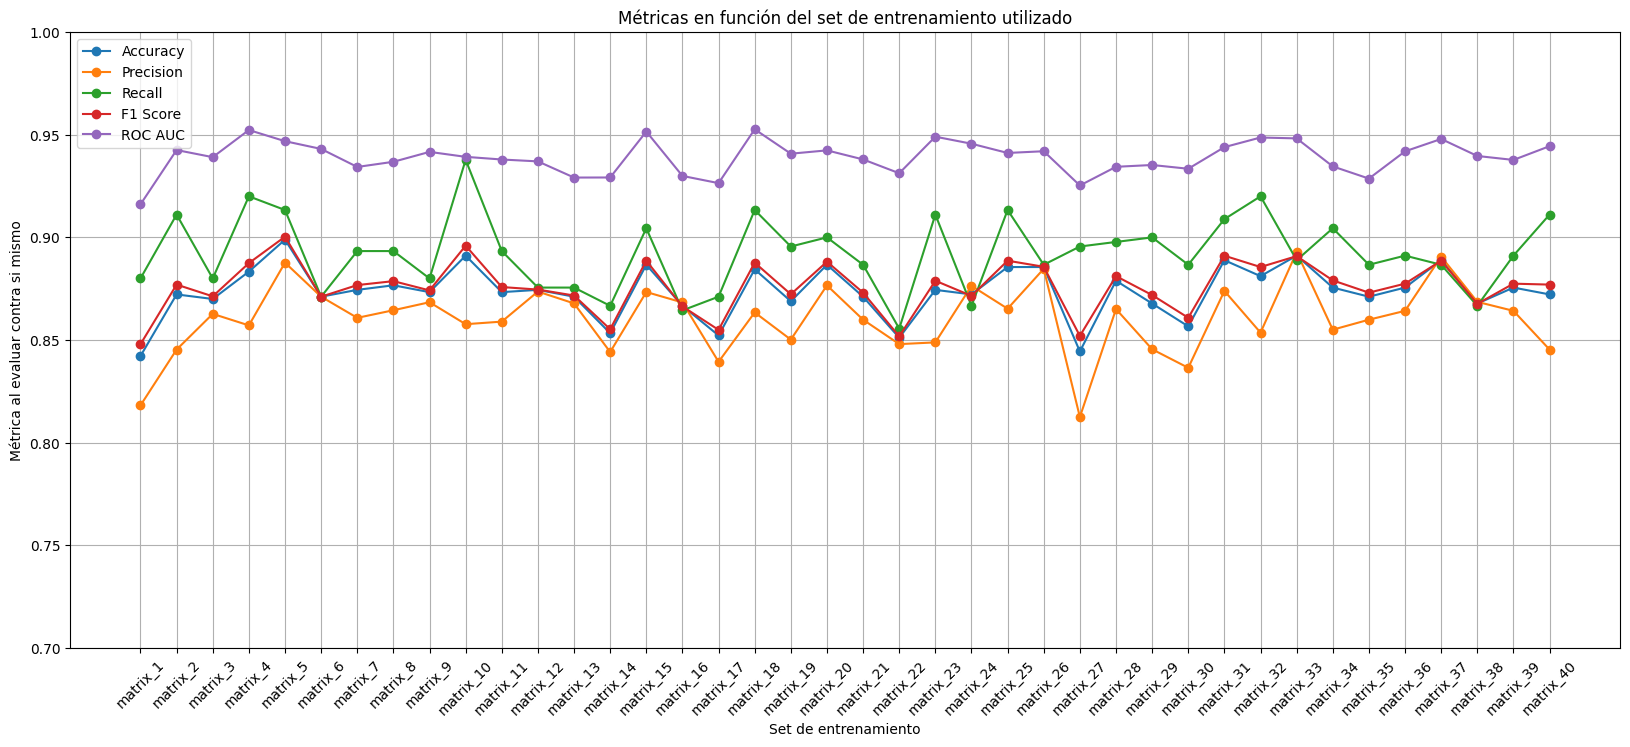

In [ ]:
# Extender etiquetas_entrenamiento hasta matrix_40
etiquetas_entrenamiento = [f"matrix_{i}" for i in range(1, 41)]

# Crear una figura y ejes
plt.figure(figsize=(20, 8))

# Graficar cada métrica
plt.plot(etiquetas_entrenamiento, self_accuracy, marker='o', label='Accuracy')
plt.plot(etiquetas_entrenamiento, self_precision, marker='o', label='Precision')
plt.plot(etiquetas_entrenamiento, self_recall, marker='o', label='Recall')
plt.plot(etiquetas_entrenamiento, self_f1, marker='o', label='F1 Score')
plt.plot(etiquetas_entrenamiento, self_roc_auc, marker='o', label='ROC AUC')
plt.ylim(0.7, 1)
# Añadir título y etiquetas
plt.title('Métricas en función del set de entrenamiento utilizado')
plt.xlabel('Set de entrenamiento')
plt.ylabel('Métrica al evaluar contra si mismo')
plt.xticks(etiquetas_entrenamiento)
plt.grid(True)

# Rotar las etiquetas del eje X
plt.xticks(etiquetas_entrenamiento, rotation=45)  # Rotación de 45 grados

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

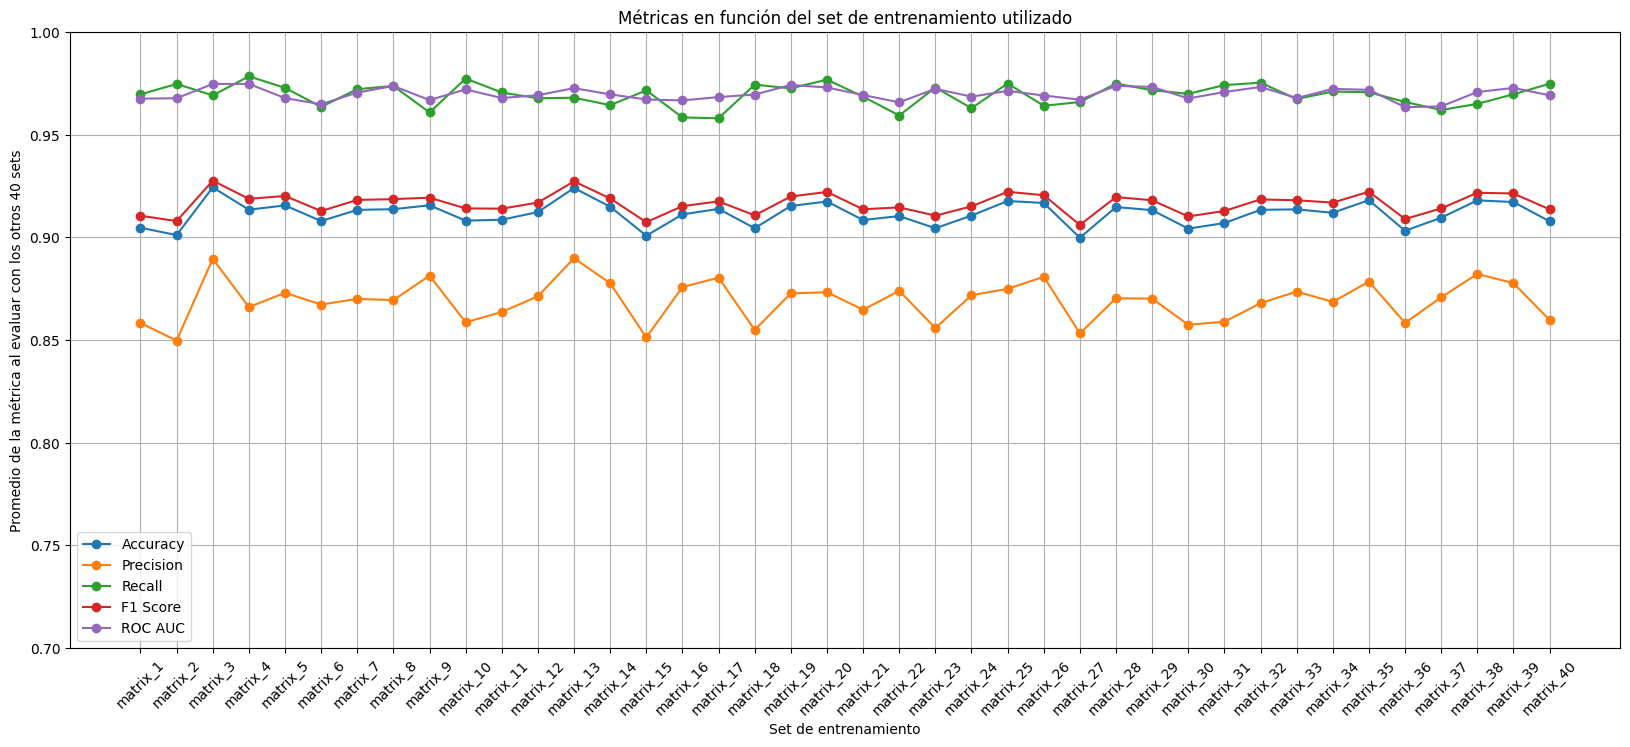

In [ ]:
# Extender etiquetas_entrenamiento hasta matrix_40
etiquetas_entrenamiento = [f"matrix_{i}" for i in range(1, 41)]

# Crear una figura y ejes
plt.figure(figsize=(20, 8))

# Graficar cada métrica
plt.plot(etiquetas_entrenamiento, other_accuracy, marker='o', label='Accuracy')
plt.plot(etiquetas_entrenamiento, other_precision, marker='o', label='Precision')
plt.plot(etiquetas_entrenamiento, other_recall, marker='o', label='Recall')
plt.plot(etiquetas_entrenamiento, other_f1, marker='o', label='F1 Score')
plt.plot(etiquetas_entrenamiento, other_roc_auc, marker='o', label='ROC AUC')
plt.ylim(0.7, 1)
# Añadir título y etiquetas
plt.title('Métricas en función del set de entrenamiento utilizado')
plt.xlabel('Set de entrenamiento')
plt.ylabel('Promedio de la métrica al evaluar con los otros 40 sets')
plt.xticks(etiquetas_entrenamiento)
plt.grid(True)

# Rotar las etiquetas del eje X
plt.xticks(etiquetas_entrenamiento, rotation=45)  # Rotación de 45 grados

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

#Validación con AmyPro

In [ ]:
data_embeddings = np.load('/content/drive/MyDrive/aggregation_itba/GitHub/embeddings_amypro.npy')
data_labels = np.load('/content/drive/MyDrive/aggregation_itba/GitHub/APR_labels_amypro.npy')

In [ ]:
vector_len = len(matrix_1)
apr_len = 2249
no_apr_len = vector_len - apr_len
vector_labels = np.concatenate([np.zeros(no_apr_len), np.ones(apr_len)])

In [ ]:
y = vector_labels

In [ ]:
# Separar el conjunto de datos en entrenamiento (train) y prueba (test)
X_train, X_test, y_train, y_test = train_test_split(matrix_2, y, test_size=0.2, stratify=y)

# Crear el modelo
model = create_model()

# Early stopping y learning rate scheduler
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

In [ ]:
# Entrenar el modelo con la matrix actual
history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping, lr_scheduler], validation_split = 0.1, verbose=0)

# Hacer predicciones en el conjunto de validación
y_pred_prob_self = model.predict(X_test)
y_pred_self = (y_pred_prob_self > 0.5).astype("int32")

# Calcular métricas y añadirlas a las listas
accuracy_self = accuracy_score(y_test, y_pred_self)
precision_self = precision_score(y_test, y_pred_self)
recall_self = recall_score(y_test, y_pred_self)
f1_self = f1_score(y_test, y_pred_self)
roc_auc_self = roc_auc_score(y_test, y_pred_prob_self)

29/29 [==============================] - 0s 2ms/step


In [ ]:
print("Accuracy: ", accuracy_self)
print("Precision: ", precision_self )
print("Recall: ", recall_self)
print("F1 Score: ", f1_self)
print("ROC AUC: ", roc_auc_self)

Accuracy:  0.8744444444444445
Precision:  0.8655097613882863
Recall:  0.8866666666666667
F1 Score:  0.8759604829857299
ROC AUC:  0.9432148148148148


In [ ]:
# Hacer predicciones en el conjunto de validación
y_pred_prob = model.predict(data_embeddings)
y_pred = (y_pred_prob > 0.5).astype("int32")


# Calcular métricas y añadirlas a las listas
accuracy_amypro = accuracy_score(data_labels, y_pred)
precision_amypro = precision_score(data_labels, y_pred)
recall_amypro = recall_score(data_labels, y_pred)
f1_amypro = f1_score(data_labels, y_pred)
roc_auc_amypro = roc_auc_score(data_labels, y_pred_prob)

print("Accuracy: ", accuracy_amypro)
print("Precision: ", precision_amypro )
print("Recall: ", recall_amypro)
print("F1 Score: ", f1_amypro)
print("ROC AUC: ", roc_auc_amypro)

340/340 [==============================] - 1s 2ms/step
Accuracy:  0.7687770712376739
Precision:  0.13983599482088907
Recall:  0.38571428571428573
F1 Score:  0.20525815647766865
ROC AUC:  0.6487206929520384


## Graficamos una proteina contra sus probabilidades

In [ ]:
df["uniprot_id"].unique()

array(['P0ABK7', 'P02766', 'P01034', 'P05067', 'P10997', 'P02647',
       'P14859', 'P61823', 'P00441', 'P23202', 'P04156', 'P01258',
       'P27986', 'P37840', 'P14621', 'P02671', 'P00698', 'Q13148',
       'P10155', 'P61769', 'P06396', 'P06654', 'Q13480', 'P28307',
       'Q5A8T4', 'P49247', 'Q96QU1', 'B1W2X5', 'Q9AD92', 'P06865',
       'Q8N3I7', 'P98161', 'P05121', 'Q9Y572', 'P18505', 'Q01974',
       'Q99678', 'P02743', 'P13569', 'O75844', 'P49810', 'Q8NEZ4',
       'Q9Y231', 'Q9NYW4', 'O60479', 'Q9HC10', 'P54132', 'P61626',
       'P06280', 'P42574', 'P29122', 'P01607', 'P35637', 'P02511',
       'P10636', 'P08195', 'P01308', 'Q8TCU4', 'P04925', 'P04273',
       'P53708', 'Q12866', 'P14922', 'Q9UHC1', 'P32770', 'P67986',
       'P05453', 'Q92973', 'Q10472', 'P15144', 'Q15428', 'P16499',
       'Q9NR23', 'O15354', 'Q86YQ2', 'O14775', 'O43347', 'Q9Y5E7',
       'Q9UKN7', 'P49750', 'P02649', 'P06881', 'P04637', 'G1UBC2',
       'Q86UK0', 'Q9Y2U8', 'P32081', 'E9P9G2', 'Q8WXD0', 'Q9NZ

In [ ]:
proteina = df[df["uniprot_id"] == "P06396"]

In [ ]:
proteina

,id_in_source,uniprot_id,category,start,end,length,source,peptide,protein_sequence,mutant,embedding,embedding_seg
26,P-0220,P06396,amyloid,213,218,6,cpad,GDCFIL,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,False,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[-0.09932509, -0.14769548, -0.22022012, -0.15..."
262,P-1699,P06396,amyloid,209,219,11,cpad,SFNNGDCFILD,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,False,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[0.1268999, -0.1903832, -0.14692163, 0.116485..."
292,P-1772,P06396,amyloid,210,224,15,cpad,FNNGDCFILDLGNNI,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,False,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[0.059517395, -0.3034308, -0.069701225, -0.03..."
381,P-0284,P06396,amyloid,213,218,6,cpad,GNCFIL,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,True,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[-0.0066315783, 0.06583285, -0.29081178, 0.16..."
384,P-0342,P06396,amyloid,213,218,6,cpad,GYCFIL,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,True,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[-0.032762818, -0.04046431, -0.362209, -0.222..."
578,P-1700,P06396,amyloid,209,219,11,cpad,SFNNGNCFILD,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,True,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[0.12874696, -0.082107425, -0.21221626, 0.062..."
579,P-1701,P06396,amyloid,209,219,11,cpad,SFNNGYCFILD,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,True,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[0.12640256, -0.13222814, -0.20467542, 0.1068..."
589,P-1773,P06396,amyloid,210,224,15,cpad,FNNGNCFILDLGNNI,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,True,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[-0.049563594, -0.35264638, -0.046607282, 0.0..."
590,P-1774,P06396,amyloid,210,224,15,cpad,FNNGYCFILDLGNNI,MAPHRPAPALLCALSLALCALSLPVRAATASRGASQAGAPQGRVPE...,True,"[[0.26311934, -0.072830066, -0.07251683, 0.376...","[[-0.010887587, -0.26654336, -0.10535247, 0.10..."


In [ ]:
embeddings_prot, APR_labels_prot, aa_vector_prot = generateInputs(proteina)

Total de aminoácidos en todas las secuencias de proteínas: 782
Longitud total de la secuencia concatenada: 782
Vector de aminoácidos: ['M' 'A' 'P' 'H' 'R' 'P' 'A' 'P' 'A' 'L' 'L' 'C' 'A' 'L' 'S' 'L' 'A' 'L'
 'C' 'A' 'L' 'S' 'L' 'P' 'V' 'R' 'A' 'A' 'T' 'A' 'S' 'R' 'G' 'A' 'S' 'Q'
 'A' 'G' 'A' 'P' 'Q' 'G' 'R' 'V' 'P' 'E' 'A' 'R' 'P' 'N' 'S' 'M' 'V' 'V'
 'E' 'H' 'P' 'E' 'F' 'L' 'K' 'A' 'G' 'K' 'E' 'P' 'G' 'L' 'Q' 'I' 'W' 'R'
 'V' 'E' 'K' 'F' 'D' 'L' 'V' 'P' 'V' 'P' 'T' 'N' 'L' 'Y' 'G' 'D' 'F' 'F'
 'T' 'G' 'D' 'A' 'Y' 'V' 'I' 'L' 'K' 'T' 'V' 'Q' 'L' 'R' 'N' 'G' 'N' 'L'
 'Q' 'Y' 'D' 'L' 'H' 'Y' 'W' 'L' 'G' 'N' 'E' 'C' 'S' 'Q' 'D' 'E' 'S' 'G'
 'A' 'A' 'A' 'I' 'F' 'T' 'V' 'Q' 'L' 'D' 'D' 'Y' 'L' 'N' 'G' 'R' 'A' 'V'
 'Q' 'H' 'R' 'E' 'V' 'Q' 'G' 'F' 'E' 'S' 'A' 'T' 'F' 'L' 'G' 'Y' 'F' 'K'
 'S' 'G' 'L' 'K' 'Y' 'K' 'K' 'G' 'G' 'V' 'A' 'S' 'G' 'F' 'K' 'H' 'V' 'V'
 'P' 'N' 'E' 'V' 'V' 'V' 'Q' 'R' 'L' 'F' 'Q' 'V' 'K' 'G' 'R' 'R' 'V' 'V'
 'R' 'A' 'T' 'E' 'V' 'P' 'V' 'S' 'W' 'E' 'S' 'F' 'N' 'N' 'G' 'D

In [ ]:
APR_labels_prot.shape

(782,)

In [ ]:
embeddings_prot.shape

(782, 1024)

In [ ]:
  # Hacer predicciones en el conjunto de validación
  y_pred_prob_prot = model.predict(embeddings_prot)
  y_pred_prot = (y_pred_prob_prot > 0.5).astype("int32")

25/25 [==============================] - 0s 2ms/step


In [ ]:
# Calcular métricas
accuracy = accuracy_score(APR_labels_prot, y_pred_prot)
precision = precision_score(APR_labels_prot, y_pred_prot)
recall = recall_score(APR_labels_prot, y_pred_prot)
f1 = f1_score(APR_labels_prot, y_pred_prot)
roc_auc = roc_auc_score(APR_labels_prot, y_pred_prot)

# Imprimir reporte de clasificación y matriz de confusión
print("Reporte de clasificación:")
print(classification_report(APR_labels_prot, y_pred_prot))
print("Matriz de confusión:")
print(confusion_matrix(APR_labels_prot, y_pred_prot))

# Imprimir métricas
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
#print(f'ROC AUC: {roc_auc:.2f}')

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86       766
         1.0       0.08      1.00      0.15        16

    accuracy                           0.76       782
   macro avg       0.54      0.88      0.50       782
weighted avg       0.98      0.76      0.85       782

Matriz de confusión:
[[579 187]
 [  0  16]]
Accuracy: 0.76
Precision: 0.08
Recall: 1.00
F1-score: 0.15


In [ ]:
aminoacido_indices = np.arange(len(y_pred_prob_prot))

In [ ]:
y_pred_prob_prot.flatten().shape

(782,)

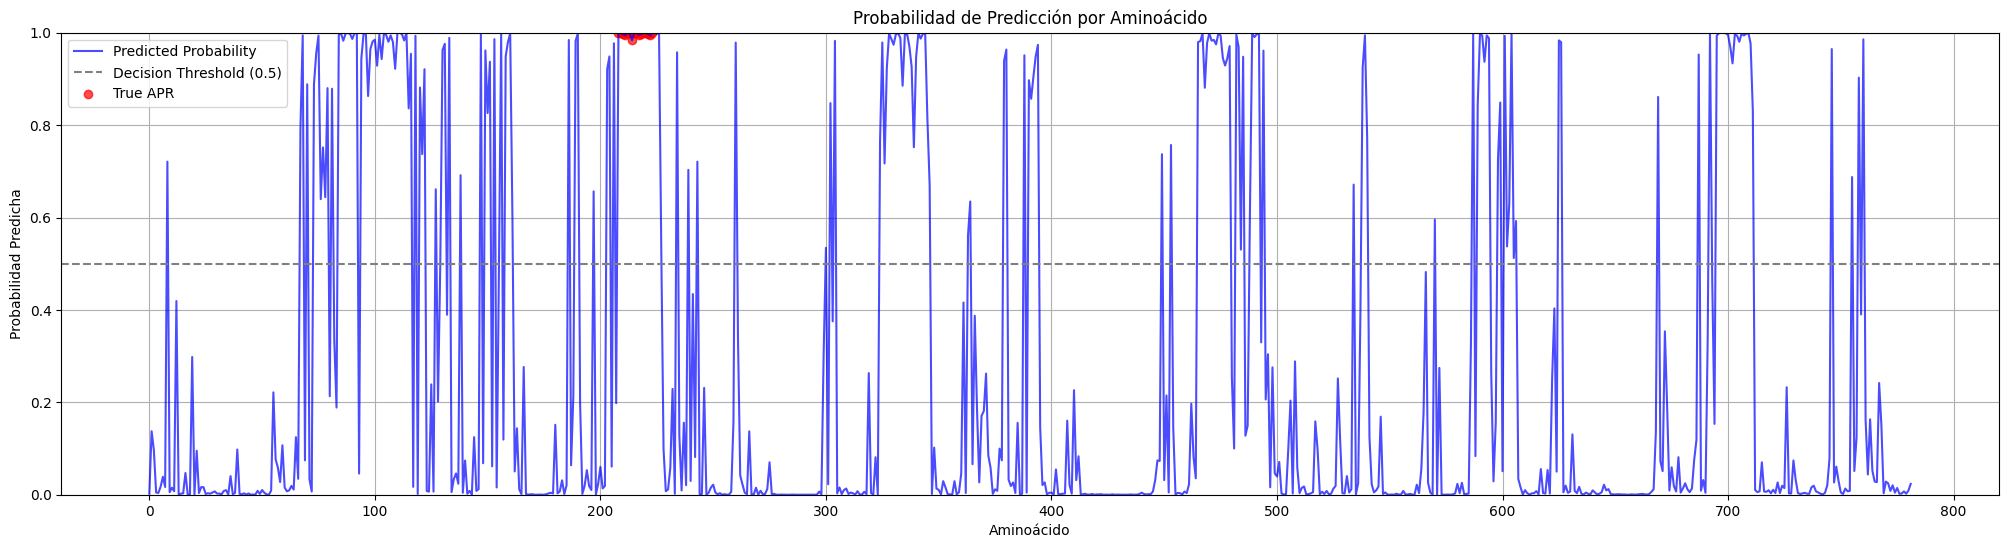

In [ ]:
# Asegurarse de que y_pred_prob_prot y APR_labels_prot sean arrays NumPy
y_pred_prob_prot = np.array(y_pred_prob_prot)
APR_labels_prot = np.array(APR_labels_prot)

# Verificar que aminoacido_indices y y_pred_prob_prot tengan la misma longitud
if len(aminoacido_indices) != len(y_pred_prob_prot):
    raise ValueError("Las longitudes de aminoacido_indices y y_pred_prob_prot no coinciden.")

# Crear una figura y ejes
plt.figure(figsize=(25, 6))

# Graficar las probabilidades predichas como barras
plt.plot(aminoacido_indices, y_pred_prob_prot.flatten(), color='blue', label='Predicted Probability', alpha=0.7)

# Añadir la línea horizontal en 0.5
plt.axhline(y=0.5, color='gray', linestyle='--', label='Decision Threshold (0.5)')

# Resaltar las barras donde APR_labels_prot es 1 (verdaderos APR)
plt.scatter(aminoacido_indices[APR_labels_prot == 1],
        y_pred_prob_prot[APR_labels_prot == 1].flatten(),
        color='red', label='True APR', alpha=0.7)

# Añadir título y etiquetas
plt.title('Probabilidad de Predicción por Aminoácido')
plt.xlabel('Aminoácido')
plt.ylabel('Probabilidad Predicha')
plt.ylim(0, 1)  # Para que la escala de probabilidad esté entre 0 y 1
plt.grid(True)

# Añadir leyenda
plt.legend()

# Mostrar la gráfica
plt.show()
